In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer,TFAutoModelForMaskedLM,TFAutoModelForSequenceClassification,TextClassificationPipeline
import pandas as pd
import numpy as np
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,classification_report,auc,roc_curve,RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# ESSENTIAL FUNCTIONS

## Data readness function

In [ ]:
def get_ds(data,Xcol,ycol,max_padding,tokenizer,transform_function=None, batch_size=32,test_ratio=0.2):

  X = data[Xcol]
  y = data[ycol]

  X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=test_ratio,random_state=42)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5,random_state=42)

  if transform_function != None:
    y_train = transform_function(y_train)
    y_val = transform_function(y_val)
    y_test = transform_function(y_test)
  

  X_train, y_train = list(X_train), y_train.tolist()
  X_eval, y_eval = list(X_val), y_val.tolist()
  X_test, y_test = list(X_test), y_test.tolist()


  train_encodings = tokenizer(X_train, truncation=True, padding='max_length',max_length=max_padding)
  eval_encodings = tokenizer(X_eval, truncation=True, padding='max_length',max_length=max_padding)
  test_encodings = tokenizer(X_test, truncation=True, padding='max_length',max_length=max_padding)

  train_ds = tf.data.Dataset.from_tensor_slices((
      dict(train_encodings),
      y_train
  ))

  eval_ds = tf.data.Dataset.from_tensor_slices((
      dict(eval_encodings),
      y_eval
  ))
  
  test_ds = tf.data.Dataset.from_tensor_slices((
      dict(test_encodings),
      y_test
  ))

  train_ds = train_ds.batch(batch_size)
  eval_ds = eval_ds.batch(batch_size)
  test_ds = test_ds.batch(batch_size)

  return train_ds,eval_ds,test_ds

## F-beta-score & Catagorical focal CrossEntropy

In [ ]:
def f_beta_score(y_true, y_pred):
  beta=1
  def recall_m(y_true, y_pred):
      TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

      recall = TP / (Positives+K.epsilon())
      return recall


  def precision_m(y_true, y_pred):
      TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

      precision = TP / (Pred_Positives+K.epsilon())
      return precision

  precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

  return (beta+1)*((precision*recall)/(precision+recall+K.epsilon()))

def focal_loss(gamma=2., alpha=0.01):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )

## Catagorical corss entropy focal loss

In [ ]:
class Catagorecal_Focal_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        sen_loss = tf.keras.losses.CategoricalCrossentropy()(y_true[:,0:3],y_pred[:,0:3])
        sa_loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,alpha = 0.6)(y_true[:,3],y_pred[:,3])
        sar_loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,alpha = 0.6)(y_true[:,4],y_pred[:,4])
        con = [sen_loss,sa_loss,sar_loss]
        y_p = tf.convert_to_tensor(con, tf.float32)

        fl = tf.reduce_mean(y_p)
        return fl

# READ DATA

In [ ]:
sentiments = pd.read_csv('/content/drive/MyDrive/MARBERT DATASET/ArSAS/ArSAS..txt',sep='\t')
sarcasm_train = pd.read_csv('/content/drive/MyDrive/MARBERT DATASET/ArSarcasm-master/ArSarcasm-master/dataset/ArSarcasm_train.csv')
sarcasm_test = pd.read_csv('/content/drive/MyDrive/MARBERT DATASET/ArSarcasm-master/ArSarcasm-master/dataset/ArSarcasm_test.csv')
sarcasm=pd.concat([sarcasm_train,sarcasm_test])

# SARCASM


## DATA VISUALIZATION

In [ ]:
sarcasm.shape

(10547, 6)

In [ ]:
sarcasm.columns

Index(['dialect', 'sarcasm', 'sentiment', 'original_sentiment', 'tweet',
       'source'],
      dtype='object')

In [ ]:
sarcasm=sarcasm.reset_index()

In [ ]:
sarcasm

,index,dialect,sarcasm,sentiment,original_sentiment,tweet,source
0,0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval
1,1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval
2,2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval
3,3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval
4,4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval
...,...,...,...,...,...,...,...
10542,2105,msa,False,neutral,positive,د علاء الأسواني: ما هي آليات التحول الديموقراط...,astd
10543,2106,msa,False,neutral,negative,#أوقفوا_الفحم في #مصر,astd
10544,2107,msa,False,neutral,positive,#الحب_هو أن تُشْبِعَ حبيبكَ اهتماماً قبل إشباع...,astd
10545,2108,egypt,False,positive,neutral,"""RT @H_alsheikh: اللهم كن لإخواننا في سوريا،ست...",semeval


In [ ]:
sarcasm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10547 entries, 0 to 10546
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               10547 non-null  int64 
 1   dialect             10547 non-null  object
 2   sarcasm             10547 non-null  bool  
 3   sentiment           10547 non-null  object
 4   original_sentiment  10547 non-null  object
 5   tweet               10547 non-null  object
 6   source              10547 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 504.8+ KB


In [ ]:
sarcasm['sarcasm'].value_counts()

False    8865
True     1682
Name: sarcasm, dtype: int64

In [ ]:
sarcasm['sarcasm']=sarcasm['sarcasm'].astype('int32')

In [ ]:
sarcasm = downsample(sarcasm, 'sarcasm')

In [ ]:
sarcasm['sarcasm'].value_counts()

0    1682
1    1682
Name: sarcasm, dtype: int64

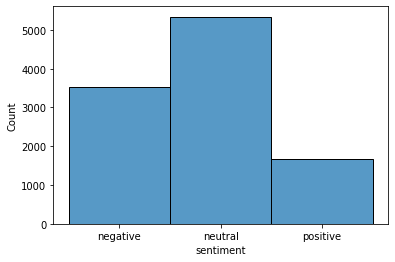

In [ ]:
sns.histplot(sarcasm,x='sentiment')

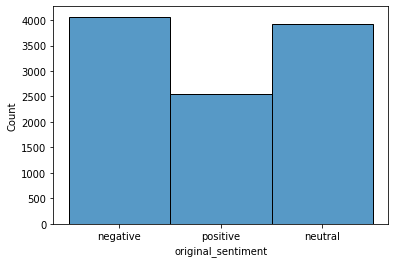

In [ ]:
sns.histplot(sarcasm,x='original_sentiment')

## MODEL

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
model_sar = TFAutoModelForSequenceClassification.from_pretrained("UBC-NLP/MARBERT",name='BERT',num_labels=1)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train,eval,test = get_ds(data=sarcasm,Xcol='tweet',ycol='sarcasm',max_padding=256,tokenizer=tokenizer)

In [ ]:
v=[]
for i in range(len(list(eval))):
  v=v+list(list(eval)[i][1].numpy())

In [ ]:
len(v)

337

In [ ]:
sum(v)

161

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-05)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='min')

model_sar.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [f_beta_score]
              )

In [ ]:
model_sar.fit(train,validation_data=eval, epochs=10)

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


85/85 [==============================] - 202s 2s/step - loss: 0.5926 - f_beta_score: 0.6548 - val_loss: 0.6064 - val_f_beta_score: 0.2067
Epoch 2/10
85/85 [==============================] - 142s 2s/step - loss: 0.4257 - f_beta_score: 0.7992 - val_loss: 0.6302 - val_f_beta_score: 0.7001
Epoch 3/10
85/85 [==============================] - 141s 2s/step - loss: 0.4310 - f_beta_score: 0.9044 - val_loss: 1.4331 - val_f_beta_score: 0.8354
Epoch 4/10
85/85 [==============================] - 145s 2s/step - loss: 0.5073 - f_beta_score: 0.8233 - val_loss: 0.4986 - val_f_beta_score: 0.7438
Epoch 5/10
85/85 [==============================] - 142s 2s/step - loss: 0.3341 - f_beta_score: 0.9113 - val_loss: 0.9645 - val_f_beta_score: 0.8303
Epoch 6/10
85/85 [==============================] - 140s 2s/step - loss: 0.2073 - f_beta_score: 0.9654 - val_loss: 1.1939 - val_f_beta_score: 0.8388
Epoch 7/10
85/85 [==============================] - 143s 2s/step - loss: 0.1762 - f_beta_score: 0.9836 - val_loss: 1.

In [ ]:
model_sar.save_pretrained('/content/drive/MyDrive/MARBERT DATASET/MODELS/sarcasmV4')

In [ ]:
y_pred = model_sar.predict(test)


11/11 [==============================] - 9s 559ms/step


In [ ]:
y_pred.logits.shape

(336, 1)

In [ ]:
y_pred

In [ ]:
y_p=[]
for i in y_pred.logits:
  if i < 0:
    y_p.append(0)
  else:
    y_p.append(1)

In [ ]:
y_true=[]
for i in range(len(list(test))):
  y_true=y_true+list(list(test)[i][1].numpy())

In [ ]:
sum(y_true)

160

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_p)
print(cm)
cm_df = pd.DataFrame(cm,
                     index = ['not sarcastic','sarcastic'], 
                     columns = ['not sarcastic','sarcastic'])

[[120  56]
 [  9 151]]


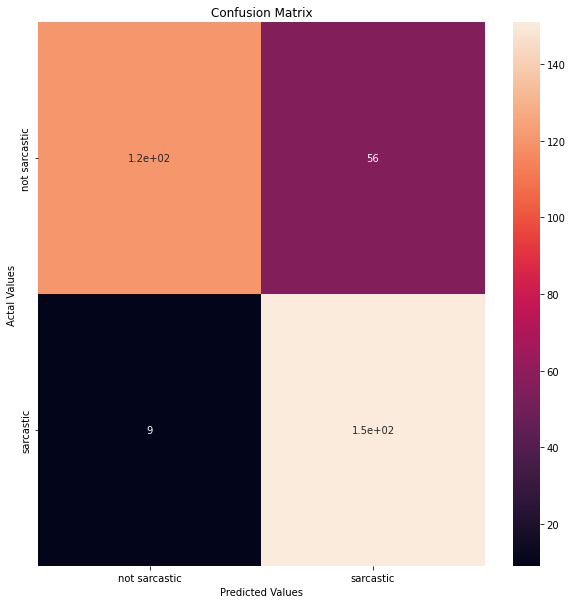

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('confusion_matrix_heamap.png')
plt.show()

In [ ]:
print(classification_report(y_true,y_p))

              precision    recall  f1-score   support

           0       0.93      0.68      0.79       176
           1       0.73      0.94      0.82       160

    accuracy                           0.81       336
   macro avg       0.83      0.81      0.80       336
weighted avg       0.83      0.81      0.80       336



In [ ]:
f1_score(y_true,y_p)

0.8228882833787466

# SPEACH ACT

## FEATURE ENGINEEERING

## DATA VISUALIZATION

In [ ]:
sentiments.shape

(19897, 7)

In [ ]:
sentiments.columns

Index(['#Tweet_ID', 'Tweet_text', 'Topic', 'Sentiment_label',
       'Sentiment_label_confidence', 'Speech_act_label',
       'Speech_act_label_confidence'],
      dtype='object')

In [ ]:
inx=sentiments[sentiments['Speech_act_label_confidence'] < 0.5].index

In [ ]:
sentiments=sentiments.drop(index=inx)

In [ ]:
sentiments['Speech_act_label'].unique()

array(['Assertion', 'Expression', 'Question', 'Request', 'Recommendation',
       'Miscellaneous'], dtype=object)

In [ ]:
sentiments['Speech_act_label'].value_counts()

Expression        10925
Assertion          7719
Question            661
Request             134
Recommendation       64
Miscellaneous        36
Name: Speech_act_label, dtype: int64

<AxesSubplot:xlabel='Speech_act_label', ylabel='Count'>

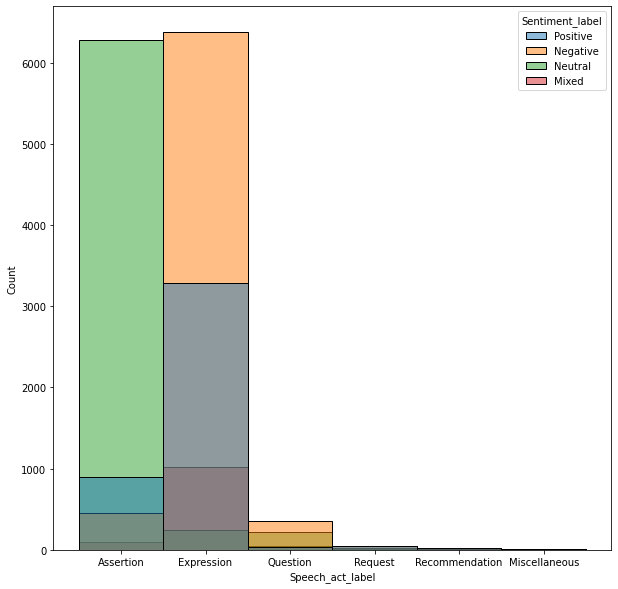

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(sentiments,x='Speech_act_label',hue='Sentiment_label')

In [ ]:
def delete(x):
  if x == 'Question' or x == 'Miscellaneous' or x == 'Request' or x == 'Recommendation':
    return 'Neither'
  else:
    return x
#sentiments['Speech_act_label'] = sentiments['Speech_act_label'].apply(delete)

In [ ]:
inx=sentiments[(sentiments['Speech_act_label'] == 'Question') | (sentiments['Speech_act_label'] == 'Miscellaneous') | (sentiments['Speech_act_label'] == 'Request') | (sentiments['Speech_act_label'] == 'Recommendation') ].index

In [ ]:
sentiments=sentiments.drop(index=inx)

<AxesSubplot:xlabel='Speech_act_label', ylabel='Count'>

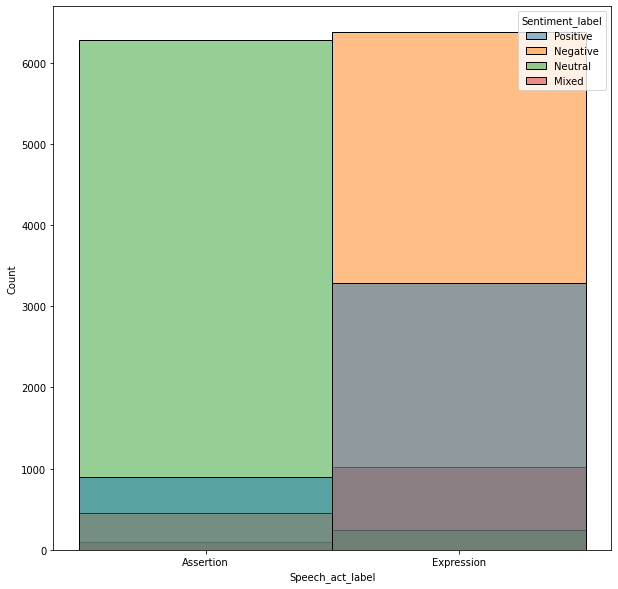

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(sentiments,x='Speech_act_label',hue='Sentiment_label')

In [ ]:
sentiments['Speech_act_label'].value_counts()

Assertion     7719
Expression    7719
Name: Speech_act_label, dtype: int64

In [ ]:
sentiments = downsample(sentiments ,'Speech_act_label' )

In [ ]:
sa_e ={'Expression':0,'Assertion':1}

In [ ]:
sentiments['Speech_act_label'] = sentiments['Speech_act_label'].apply(lambda x : sa_e[x])

<AxesSubplot:xlabel='Speech_act_label_confidence', ylabel='Count'>

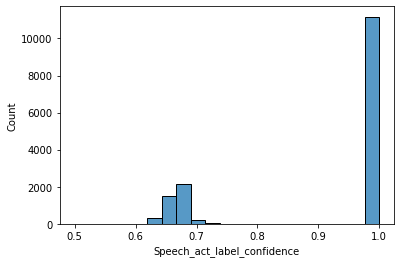

In [ ]:
sns.histplot(sentiments,x='Speech_act_label_confidence')

## MODEL

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
model_sa = TFAutoModelForSequenceClassification.from_pretrained("UBC-NLP/MARBERT",name='BERT',num_labels=1)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train,eval,test = get_ds(data=sentiments,Xcol='Tweet_text',ycol='Speech_act_label',max_padding=256,tokenizer=tokenizer)

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-05)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='min')

model_sa.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = [f_beta_score]
              )

In [ ]:
model_sa.fit(train,validation_data=eval, epochs=10)

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


386/386 [==============================] - 102s 211ms/step - loss: 0.2359 - f_beta_score: 0.9052 - val_loss: 0.1878 - val_f_beta_score: 0.9335
Epoch 2/10
386/386 [==============================] - 78s 203ms/step - loss: 0.1318 - f_beta_score: 0.9475 - val_loss: 0.2378 - val_f_beta_score: 0.9197
Epoch 3/10
386/386 [==============================] - 78s 203ms/step - loss: 0.0762 - f_beta_score: 0.9717 - val_loss: 0.3158 - val_f_beta_score: 0.9139
Epoch 4/10
386/386 [==============================] - 79s 203ms/step - loss: 0.0531 - f_beta_score: 0.9824 - val_loss: 0.3587 - val_f_beta_score: 0.9170
Epoch 5/10
386/386 [==============================] - 78s 203ms/step - loss: 0.0337 - f_beta_score: 0.9878 - val_loss: 0.3997 - val_f_beta_score: 0.9106
Epoch 6/10
386/386 [==============================] - 78s 203ms/step - loss: 0.0295 - f_beta_score: 0.9897 - val_loss: 0.5695 - val_f_beta_score: 0.8832
Epoch 7/10
386/386 [==============================] - 78s 203ms/step - loss: 0.0261 - f_beta

In [ ]:
model_sa.save_pretrained('/content/drive/MyDrive/MARBERT DATASET/MODELS/speach_actV5')

In [ ]:
y_pred = model_sa.predict(test)

49/49 [==============================] - 4s 73ms/step


In [ ]:
y_pred.logits

array([[ 0.12810872],
       [-8.394683  ],
       [ 8.032023  ],
       ...,
       [ 8.077981  ],
       [ 6.9774036 ],
       [-6.203824  ]], dtype=float32)

In [ ]:
y_p=[]
for i in y_pred.logits:
    y_p.append(i)

In [ ]:
y_p

In [ ]:
y_true=[]
for i in range(len(list(test))):
  y_true=y_true+list(list(test)[i][1].numpy())

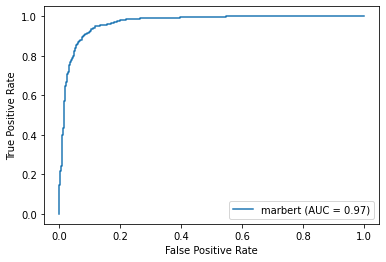

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_p)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='marbert')
display.plot()
plt.show()

In [ ]:
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
threshold = round(thresholds[index], ndigits = 4)
threshold

6.1703

In [ ]:
for i,v in enumerate(y_p):
  if v <threshold:
    y_p[i]=0
  else:
    y_p[i]=1

In [ ]:
print(len(y_true),' ',len(y_p))

1544   1544


[[683  79]
 [ 50 732]]


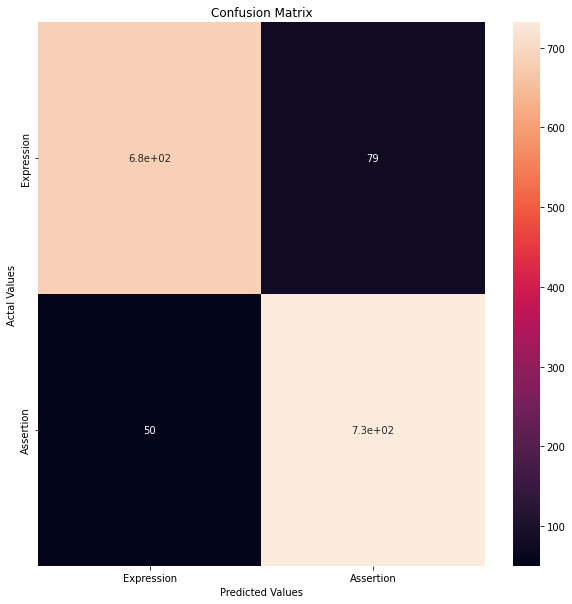

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_p)
print(cm)
cm_df = pd.DataFrame(cm,
                     index = ['Expression','Assertion'], 
                     columns = ['Expression','Assertion'])
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('confusion_matrix_heamap.png')
plt.show()

In [ ]:
print(classification_report(y_true,y_p))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       762
           1       0.90      0.94      0.92       782

    accuracy                           0.92      1544
   macro avg       0.92      0.92      0.92      1544
weighted avg       0.92      0.92      0.92      1544



In [ ]:
f1_score(y_true,y_p,average='weighted')

0.9164009255536206

# PREPARE DATA

In [ ]:
sentiments.columns

Index(['#Tweet_ID', 'Tweet_text', 'Topic', 'Sentiment_label',
       'Sentiment_label_confidence', 'Speech_act_label',
       'Speech_act_label_confidence'],
      dtype='object')

In [ ]:
inx = sentiments[(sentiments['Speech_act_label_confidence'] < 0.5) | (sentiments['Sentiment_label_confidence'] < 0.5)].index
sentiments = sentiments.drop(index=inx)
inx=sentiments[(sentiments['Speech_act_label'] == 'Question') | (sentiments['Speech_act_label'] == 'Miscellaneous') | (sentiments['Speech_act_label'] == 'Request') | (sentiments['Speech_act_label'] == 'Recommendation') ].index
sentiments=sentiments.drop(index=inx)

In [ ]:
sentiments=sentiments.drop(columns=['#Tweet_ID','Topic','Sentiment_label_confidence','Speech_act_label_confidence'],axis=1)

In [ ]:
sentiments.columns

Index(['Tweet_text', 'Sentiment_label', 'Speech_act_label'], dtype='object')

In [ ]:
sentiments.columns = ['tweet','sentiment','speech_act']

In [ ]:
sentiments.columns

Index(['tweet', 'sentiment', 'speech_act'], dtype='object')

In [ ]:
sarcasm.columns

Index(['dialect', 'sarcasm', 'sentiment', 'original_sentiment', 'tweet',
       'source'],
      dtype='object')

In [ ]:
sarcasm = sarcasm.drop(columns=['dialect','original_sentiment','source'])

In [ ]:
sarcasm.columns

Index(['sarcasm', 'sentiment', 'tweet'], dtype='object')

In [ ]:
sarcasm = sarcasm.loc[:,['tweet','sentiment','sarcasm']]

In [ ]:
sarcasm.columns

Index(['tweet', 'sentiment', 'sarcasm'], dtype='object')

In [ ]:
sarcasm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10547 entries, 0 to 2109
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      10547 non-null  object
 1   sentiment  10547 non-null  object
 2   sarcasm    10547 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 257.5+ KB


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
model_sa = TFAutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/MARBERT DATASET/MODELS/speach_actV5",name='BERT')
model_sn = TFAutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/MARBERT DATASET/MODELS/sarcasmV4",name='BERT')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/MARBERT DATASET/MODELS/speach_actV5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
Some layers from the model checkpoint at /content/drive/MyDrive/MARBERT DATASET/MODELS/sarcasmV4 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (in

In [ ]:
def get_sarcasm(txt):
  tokens = tokenizer(txt,truncation=True, padding='max_length',max_length=256,return_tensors='tf')
  p = model_sn.predict(dict(tokens)).logits
  return p
def get_speach_act(txt):
  tokens=tokenizer(txt,truncation=True, padding='max_length',max_length=256,return_tensors='tf')
  p = model_sa.predict(dict(tokens)).logits
  return p

In [ ]:
sa_p = get_speach_act(list(sarcasm['tweet'].values))
sar_p = get_sarcasm(list(sentiments['tweet'].values))

550/550 [==============================] - 311s 561ms/step


In [ ]:
sar_p = sar_p > 0
sa_p = sa_p > 6.1703

In [ ]:
sarcasm['speech_act'] = sa_p
sentiments['sarcasm'] = sar_p

In [ ]:
sarcasm = sarcasm.loc[:,['tweet','sentiment','speech_act','sarcasm']]

In [ ]:
sarcasm.columns

Index(['tweet', 'sentiment', 'speech_act', 'sarcasm'], dtype='object')

In [ ]:
sentiments.columns

Index(['tweet', 'sentiment', 'speech_act', 'sarcasm'], dtype='object')

In [ ]:
sarcasm['speech_act'].unique()

array([False,  True])

In [ ]:
df = pd.concat([sarcasm,sentiments],ignore_index=True,axis=0)

In [ ]:
df

,tweet,sentiment,speech_act,sarcasm
0,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",negative,False,False
1,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",neutral,True,False
2,"""@Alito_NBA اتوقع انه بيستمر""",neutral,False,False
3,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",neutral,False,True
4,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",neutral,True,False
...,...,...,...,...
28139,ملخص مباراة نيجيريا vs الجزائر تصفيات كأس 🏆 ال...,Neutral,Assertion,False
28140,ايطاليا في السان سيرو لعبت 42 مباراة 🇮🇹 31 فوز...,Positive,Expression,False
28141,المُلحق المؤهل لكأس العالم 🇪🇺أوروبا🇪🇺 مباراة ا...,Neutral,Assertion,False
28142,رسائل وتوصيات منتدى شباب العالم .. د. عبدالله ...,Neutral,Assertion,False


In [ ]:
df.loc[:,'sentiment'][df['sentiment'] == 'neutral']= 'Neutral'
df.loc[:,'sentiment'][df['sentiment'] == 'positive'] = 'Positive'
df.loc[:,'sentiment'][df['sentiment'] == 'negative'] = 'Negative'

<ipython-input-32-b50184f46ea1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'sentiment'][df['sentiment'] == 'neutral']= 'Neutral'
<ipython-input-32-b50184f46ea1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'sentiment'][df['sentiment'] == 'positive'] = 'Positive'
<ipython-input-32-b50184f46ea1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'sentiment'][df['sentiment'] == 'negative'] = 'Negative'


In [ ]:
df.loc[:,'speech_act'][df['speech_act'] == 'Expression']= False
df.loc[:,'speech_act'][df['speech_act'] == 'Assertion'] = True

<ipython-input-35-28eb150de73a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'speech_act'][df['speech_act'] == 'Expression']= False
<ipython-input-35-28eb150de73a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'speech_act'][df['speech_act'] == 'Assertion'] = True


In [ ]:
df['sentiment'].value_counts()

Neutral     11684
Negative    10041
Positive     5583
Mixed         836
Name: sentiment, dtype: int64

In [ ]:
df['speech_act'].value_counts()

False    15787
True     12357
Name: speech_act, dtype: int64

In [ ]:
df['sarcasm'].value_counts()

False    18873
True      9271
Name: sarcasm, dtype: int64

In [ ]:
df.to_csv('/content/drive/MyDrive/MARBERT DATASET/final_data2.csv',index=False)

# FINAL MODEL

## READ DATA

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MARBERT DATASET/final_data2.csv')

## FEATURE ENGINEERING

In [ ]:
data.columns

Index(['tweet', 'sentiment', 'speech_act', 'sarcasm'], dtype='object')

In [ ]:
ind = data[data['sentiment'] == 'Mixed'].index
data = data.drop(index = ind).reset_index(drop = True)

In [ ]:
print(data['sentiment'].value_counts())
print(data['sarcasm'].value_counts())
print(data['speech_act'].value_counts())

Neutral     11684
Negative    10041
Positive     5583
Name: sentiment, dtype: int64
False    18670
True      8638
Name: sarcasm, dtype: int64
False    14992
True     12316
Name: speech_act, dtype: int64


In [ ]:
print(1-(data['sentiment'].value_counts()/data.shape[0]))
print(1-(data['sarcasm'].value_counts()/data.shape[0]))
print(1-(data['speech_act'].value_counts()/data.shape[0]))

Neutral     0.572140
Negative    0.632306
Positive    0.795554
Name: sentiment, dtype: float64
False    0.316318
True     0.683682
Name: sarcasm, dtype: float64
False    0.451003
True     0.548997
Name: speech_act, dtype: float64


In [ ]:
speech_act_E = {False:0,True:1}
sarcasm_E = {False:0,True:1}
sentiment_E = {'Positive':0,'Neutral':1,'Negative':2}

In [ ]:
data['sentiment']=data['sentiment'].apply(lambda x : sentiment_E[x])
data['sarcasm']=data['sarcasm'].apply(lambda x : sarcasm_E[x])
data['speech_act']=data['speech_act'].apply(lambda x : speech_act_E[x])

In [ ]:
data = downsample(data,'sentiment')

In [ ]:
print(data['sentiment'].value_counts())
print(data['sarcasm'].value_counts())
print(data['speech_act'].value_counts())

0    5583
1    5583
2    5583
Name: sentiment, dtype: int64
0    11374
1     5375
Name: sarcasm, dtype: int64
0    10159
1     6590
Name: speech_act, dtype: int64


## MODEL

In [ ]:
def transform_num_labels(arr):
  result = np.zeros([arr.shape[0],5])
  arr = arr.to_numpy()
  result[:,0:3][np.arange(arr.shape[0]), arr[:,0]] = 1
  result[:,3] = arr[:,1]
  result[:,4] = arr[:,2]
  
  return result

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
model = TFAutoModelForMaskedLM.from_pretrained("UBC-NLP/MARBERT",name='BERT')
Fmodel = TFAutoModelForSequenceClassification.from_pretrained("UBC-NLP/MARBERT",name='BERT',num_labels=5)


In [ ]:
train,eval,test = get_ds(data=data,Xcol='tweet',ycol=['sentiment','speech_act','sarcasm'],transform_function = transform_num_labels,max_padding=256,tokenizer=tokenizer)

In [ ]:
input_ids = tf.keras.Input(shape=(256, ),dtype='int32',name='input_ids')
attention_mask = tf.keras.Input(shape=(256, ), dtype='int32',name='attention_mask')

transformer = model([input_ids, attention_mask],output_hidden_states=True)  
cls = transformer.hidden_states[-1][:,0,:]
drop_out = tf.keras.layers.Dropout(0.75)(cls)

sentiment = tf.keras.layers.Dense(32,activation='tanh',name='sentiment_1')(drop_out)
sentiment = tf.keras.layers.Dropout(0.5,name='sentiment_2')(sentiment)
sentiment = tf.keras.layers.Dense(3,activation='softmax',name='sentiment_out')(sentiment)

speech_act = tf.keras.layers.Dense(32,activation='tanh',name='speech_act_1')(drop_out)
speech_act = tf.keras.layers.Dropout(0.5,name='speech_act_2')(speech_act)
speech_act = tf.keras.layers.Dense(1,activation='sigmoid',name='speech_act_out')(speech_act)

sarcasm = tf.keras.layers.Dense(32,activation='tanh',name='sarcasm_1')(drop_out)
sarcasm = tf.keras.layers.Dropout(0.5,name='sarcasm_2')(sarcasm)
sarcasm = tf.keras.layers.Dense(1,activation='sigmoid',name='sarcasm_out')(sarcasm)

output = tf.keras.layers.Concatenate(axis = -1)([sentiment,speech_act,sarcasm])

Fmodel = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)


In [ ]:
Fmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 BERT (TFBertForMaskedLM)       TFMaskedLMOutput(lo  162942880   ['input_ids[0][0]',              
                                ss=None, logits=(No               'attention_mask[0][0]']         
                                ne, 256, 100000),                                                 
                                 hidden_states=((No                                           

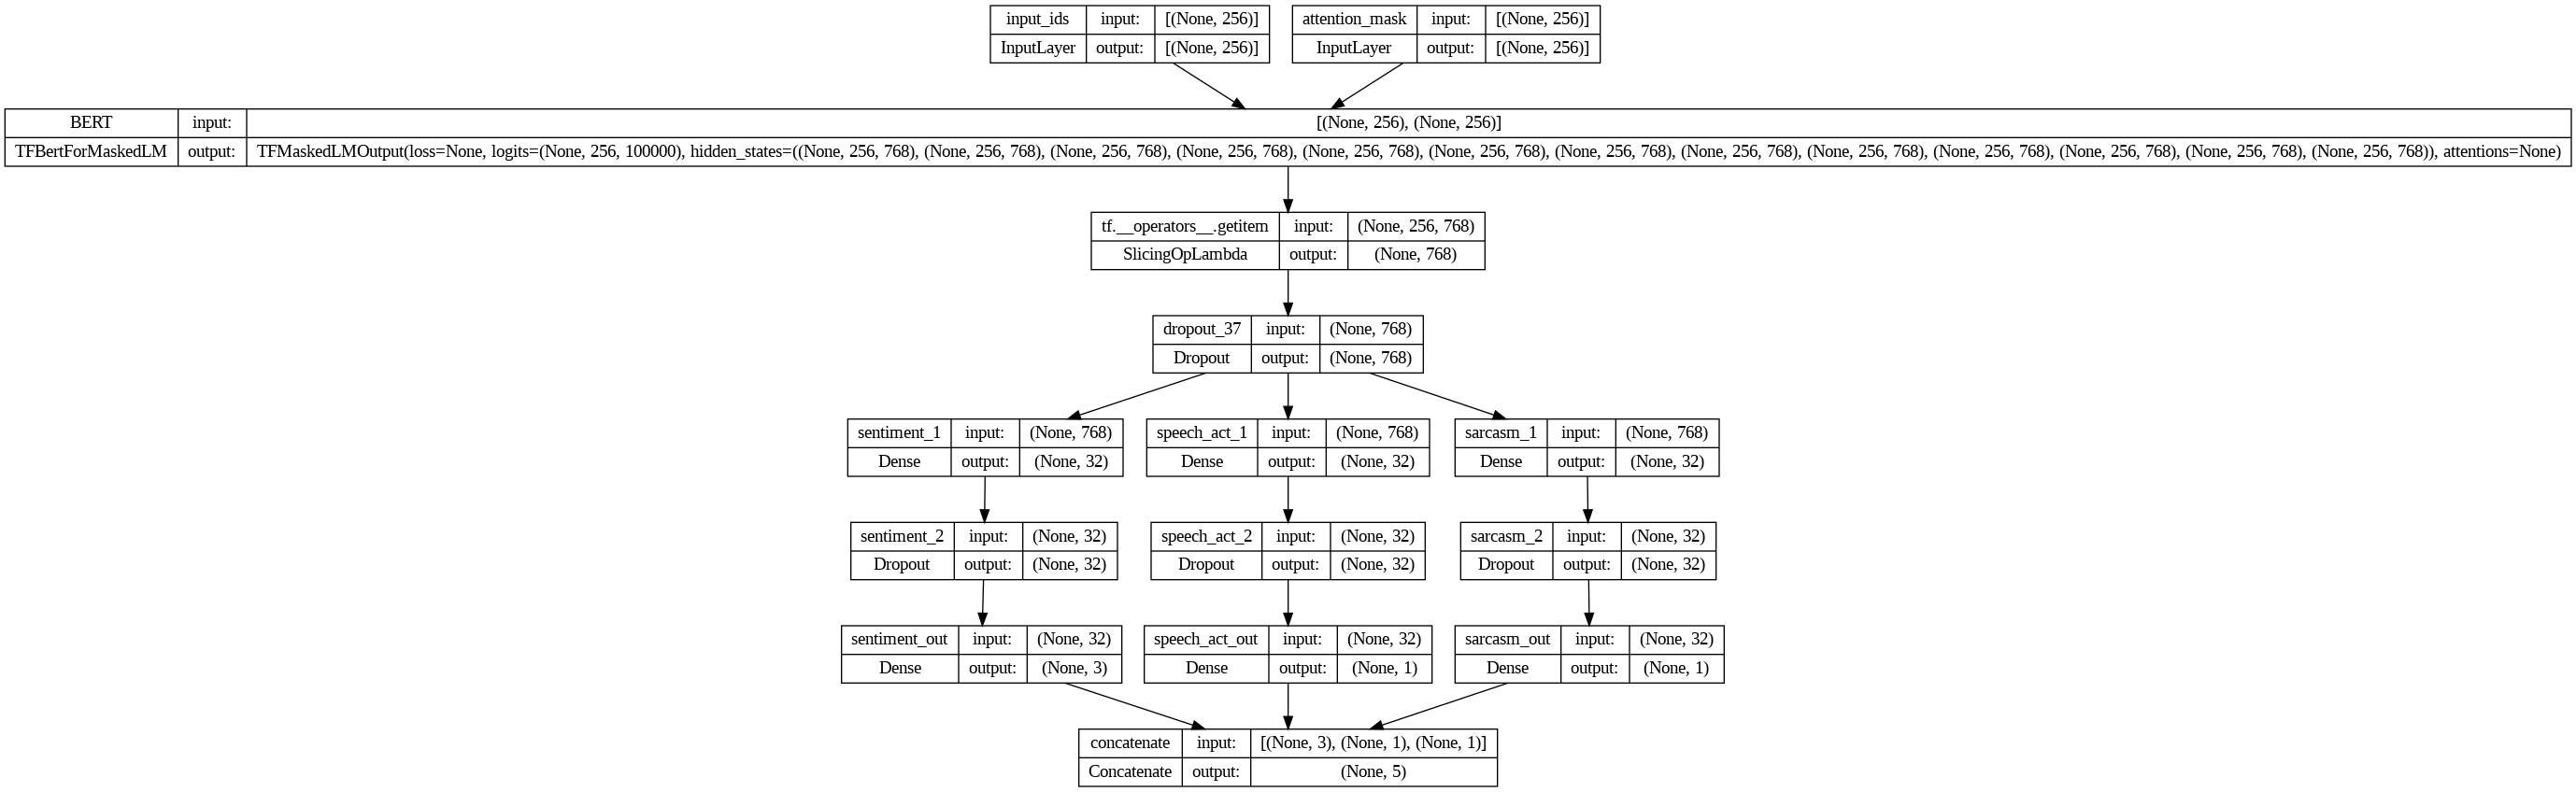

In [ ]:
tf.keras.utils.plot_model(Fmodel,to_file='model.png', show_shapes=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-05)

Fmodel.compile(optimizer = optimizer,
              loss = Catagorecal_Focal_loss(),
              metrics = [f_beta_score]
              )


In [ ]:
cb = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/MARBERT DATASET/MODELS/W',
    save_best_only= True
)

In [ ]:
Fmodel.fit(train,validation_data=eval, epochs=20, callbacks= [cb])

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


419/419 [==============================] - ETA: 0s - loss: 0.3433 - f_beta_score: 0.6741

419/419 [==============================] - 214s 402ms/step - loss: 0.3433 - f_beta_score: 0.6741 - val_loss: 0.2425 - val_f_beta_score: 0.7832
Epoch 2/20
419/419 [==============================] - 85s 203ms/step - loss: 0.2262 - f_beta_score: 0.7907 - val_loss: 0.2885 - val_f_beta_score: 0.8115
Epoch 3/20
419/419 [==============================] - 85s 202ms/step - loss: 0.1706 - f_beta_score: 0.8412 - val_loss: 0.3098 - val_f_beta_score: 0.8106
Epoch 4/20
419/419 [==============================] - 85s 202ms/step - loss: 0.1284 - f_beta_score: 0.8756 - val_loss: 0.3637 - val_f_beta_score: 0.8105
Epoch 5/20
419/419 [==============================] - 85s 202ms/step - loss: 0.0988 - f_beta_score: 0.8998 - val_loss: 0.3342 - val_f_beta_score: 0.8115
Epoch 6/20
419/419 [==============================] - 85s 202ms/step - loss: 0.0788 - f_beta_score: 0.9195 - val_loss: 0.3929 - val_f_beta_score: 0.8097
Epoch 7/20
419/419 [==============================] - 85s 202ms/step - loss: 0.0650 - f_beta

In [ ]:
Fmodel.save('/content/drive/MyDrive/MARBERT DATASET/MODELS/final')

In [ ]:
tf.keras.models.save_model(Fmodel,'/content/drive/MyDrive/MARBERT DATASET/MODELS/final2')

In [ ]:
list(test)[0][1].numpy().shape

(32, 5)

In [ ]:
y_true_1=[]
y_true_2=[]
y_true_3=[]
for i in range(len(list(test))):
  y_true_1 = y_true_1 + list(np.argmax(list(test)[i][1].numpy()[:,0:3],axis=1))
  y_true_2 = y_true_2 + list(list(test)[i][1].numpy()[:,3])
  y_true_3 = y_true_3 + list(list(test)[i][1].numpy()[:,4])

In [ ]:
y_p = Fmodel.predict(test)

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


53/53 [==============================] - 7s 70ms/step


In [ ]:
y_p.shape

(1675, 5)

In [ ]:
y_pred_1 = np.argmax(y_p[:,0:3],axis=1).tolist()
y_pred_2 = y_p[:,3].tolist()
y_pred_3 = y_p[:,4].tolist()

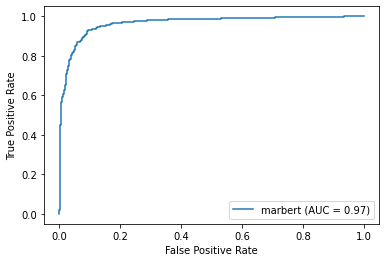

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true_2, y_pred_2)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='marbert')
display.plot()
plt.show()

In [ ]:
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
threshold_2 = round(thresholds[index], ndigits = 4)
threshold_2

0.664

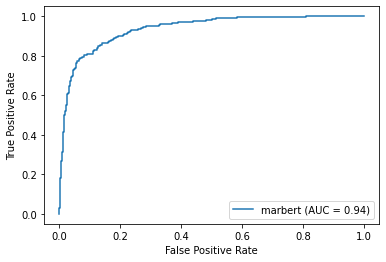

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true_3, y_pred_3)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='marbert')
display.plot()
plt.show()

In [ ]:
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
threshold_3 = round(thresholds[index], ndigits = 4)
threshold_3

0.0975

In [ ]:
for i,v in enumerate(y_pred_2):
  if v < threshold_2:
    y_pred_2[i] = 0
  else:
    y_pred_2[i] = 1

In [ ]:
for i,v in enumerate(y_pred_3):
  if v < threshold_3:
    y_pred_3[i] = 0
  else:
    y_pred_3[i] = 1

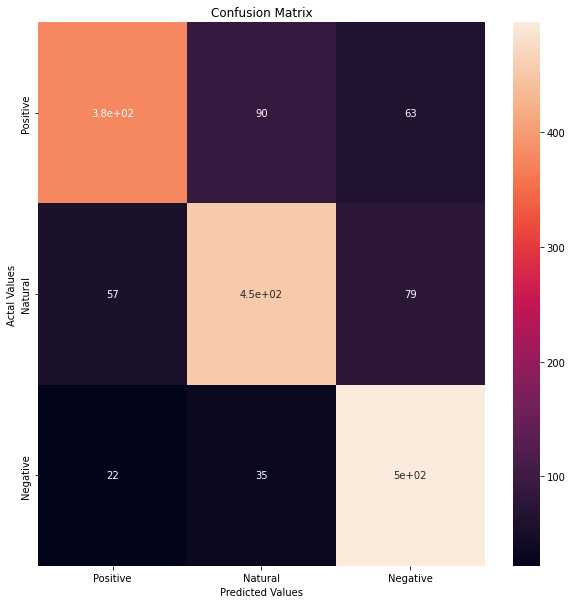

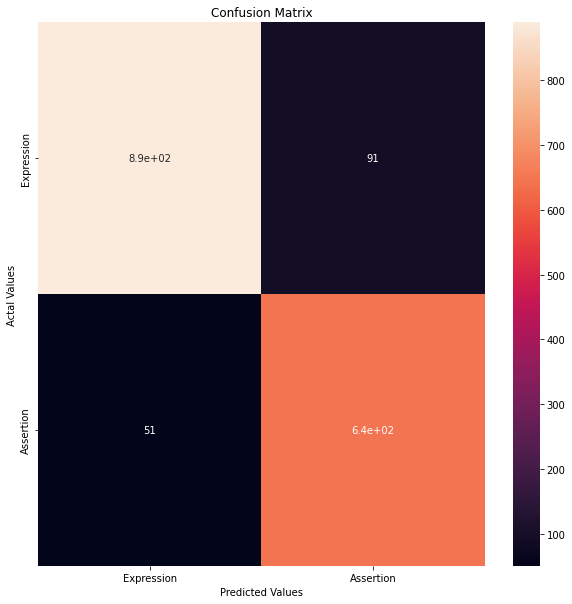

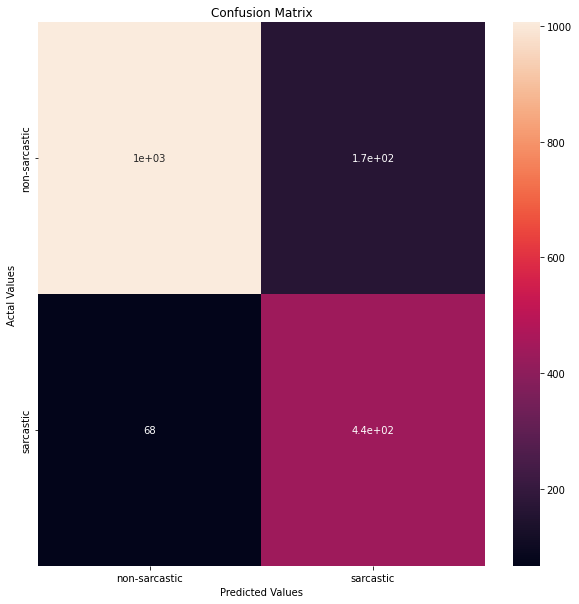

In [ ]:
cm = confusion_matrix(y_true=y_true_1, y_pred=y_pred_1)
cm_df = pd.DataFrame(cm,
                     index = ['Positive','Natural','Negative'], 
                     columns = ['Positive','Natural','Negative'])
  
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('confusion_matrix_heamap_sentiment.png')
plt.show()

cm = confusion_matrix(y_true=y_true_2, y_pred=y_pred_2)
cm_df = pd.DataFrame(cm,
                     index = ['Expression','Assertion'], 
                     columns = ['Expression','Assertion'])
  
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('confusion_matrix_heamap_sentiment.png')
plt.show()

cm = confusion_matrix(y_true=y_true_3, y_pred=y_pred_3)
cm_df = pd.DataFrame(cm,
                     index = ['non-sarcastic','sarcastic'], 
                     columns = ['non-sarcastic','sarcastic'])
  
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('confusion_matrix_heamap_sentiment.png')
plt.show()


In [ ]:
print(classification_report(y_true_1,y_pred_1))
print(classification_report(y_true_2,y_pred_2))
print(classification_report(y_true_3,y_pred_3))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       532
           1       0.78      0.77      0.78       590
           2       0.78      0.90      0.83       553

    accuracy                           0.79      1675
   macro avg       0.80      0.79      0.79      1675
weighted avg       0.80      0.79      0.79      1675

              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       980
         1.0       0.88      0.93      0.90       695

    accuracy                           0.92      1675
   macro avg       0.91      0.92      0.91      1675
weighted avg       0.92      0.92      0.92      1675

              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90      1172
         1.0       0.72      0.86      0.79       503

    accuracy                           0.86      1675
   macro avg       0.83      0.86      0.84      1675
weighted avg       0

In [ ]:
print(f1_score(y_true_1,y_pred_1,average='weighted'))
print(f1_score(y_true_2,y_pred_2))
print(f1_score(y_true_3,y_pred_3))

0.791762684051286
0.9006993006993007
0.7880434782608696


# CONVERT MODEL TO TF - LITE

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/MARBERT DATASET/MODELS/final')
tflite_model = converter.convert()
with open('/content/drive/MyDrive/MARBERT DATASET/MODELS/tf-lite/model.tflite', 'wb') as f:
  f.write(tflite_model)

# INFERANCE

In [ ]:
from transformers import AutoTokenizer
import numpy as np
import tensorflow as tf

In [ ]:
def get_prediction(text,model,tokenizer):
  tokens = tokenizer(text,truncation=True, padding='max_length',max_length=256,return_tensors='tf')

  preds = model(input_ids=tokens['input_ids'],attention_mask=tokens['attention_mask'])['concatenate'].flatten()
  sentiments_e = {0:'Positive',1:'Natural',2:'Negative'}
  speech_ace_e = {0:'Expression',1:'Assertion'}
  sarcasm_e = {0:'non-sarcastic',1:'sarcastic'}
  thres_1 = 0.664
  thres_2 = 0.5
  sen = np.argmax(preds[:3])
  sa = (preds[3] >= thres_1).astype('int32')
  sar = (preds[4] >= thres_2).astype('int32')

  sa_cof = (1-preds[3],preds[3])
  sar_conf = (1-preds[4],preds[4])

  res = {'sentiment': sentiments_e[sen],'sentiment_conf':round(preds[sen],ndigits=2)*100,'speech_act':speech_ace_e[sa],'speech_act_conf':round(sa_cof[sa],ndigits=2)*100,'sarcasm':sarcasm_e[sar],'sarcasm_conf':round(sar_conf[sar],ndigits=2)*100}
  return res

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/MARBERT DATASET/MODELS/tokenizer')
interpreter = tf.lite.Interpreter('/content/drive/MyDrive/MARBERT DATASET/MODELS/tf-lite/model.tflite')
model = interpreter.get_signature_runner()

In [ ]:
get_prediction('انا حزين ولله ما لقيت داتا سعودية , كنت اتمنى القى داتا سعودية',model,tokenizer)

{'sentiment': 'Negative',
 'sentiment_conf': 100.0,
 'speech_act': 'Expression',
 'speech_act_conf': 99.0,
 'sarcasm': 'non-sarcastic',
 'sarcasm_conf': 99.0}